# Neural Network Using PyTorch

Author: Sahngyoon Rhee

Neural Network puts together various simplier machine learning models, increasing the complexity and therefore flexibility in the final model. Its idea is derived from the way that some neuroscientists think that the nuerons in the human brain works.

In [1]:
from IPython.display import Image, HTML
display(HTML("""
<div style = "display: flex; justify-content: space-around;">
    <img src='human_neurons.jpg' width='500' height='300'>
    <img src='neural_network.jpg' width='400' height='300'>
</div>
"""))

The goal of this notebook is not to explain the nitty gritty details of how a neural network works. That would involve explaining the forward propagation, backward propagation, gradient descent, activation functions, hidden layers, etc. and you can find the information easily online.

The goal of this notebook is to demonstrate how to build a simple neural network using PyTorch, which along with Tensorflow is one of the most popular deep learning frameworks in Python.

The following code is from PyTorch's starter guide, and it uses the `FashionMNIST` dataset.

## Preparing data for training

We first import the necessary packages and our data. We then use the `Dataset` under `torch.utils.data` - `Dataset` retrives our dataset's features and labels one sample at a time. Later, we shall use `DataLoader` to wrap the `Dataset` as iterable and in batches. We shall later pass sample in minibatches, reshuffling the data at every epoch to reduce model overfitting, and us Python's `multiprocessing` to retrieve our data faster.

In [2]:
# uncomment the following line if you don't have PyTorch installed yet
# it'll take a couple minutes to finish install
# !pip install torch torchvision torchaudio

In [3]:
import torch
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt

training_data = datasets.FashionMNIST(
    root='data', # path where the train/test data is stored
    train=True, # if False, it means that the dataset is test dataset
    download=True, # downloads the data from the internet if it's not available at `root`
    transform=ToTensor() # specify the feature transformations
)

test_data = datasets.FashionMNIST(
    root = 'data',
    train = False,
    download = True,
    transform = ToTensor()
)

Now that we have loaded our data, we shall wrap them as iterables using `DataLoader`. Notice that the `s` in `torch.utils.data.Dataset` is in small case while the `L` in `DataLoader` is capitalized.

In [4]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(training_data, batch_size = 64, shuffle = True)
test_dataloader = DataLoader(test_data, batch_size = 64, shuffle = True)

We can now iterate through the DataLoader object.

We shall visualize a sample image. Notice that the batches reshuffle afterall batches have been iterated through. 

Feature batch shape: torch.Size([64, 1, 28, 28])
Label batch shape: torch.Size([64])


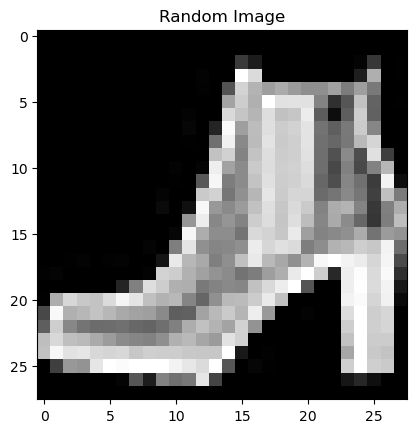

Label: Ankle Boot


In [5]:
# get the names for each label
labels_map = {
    0: "T-Shirt",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle Boot",
}

# Display a sample image and label
print(f'We shall visualize a sample image. Notice that the batches reshuffle after\
all batches have been iterated through. \n')
train_features, train_labels = next(iter(train_dataloader))
print(f'Feature batch shape: {train_features.size()}')
print(f'Label batch shape: {train_labels.size()}')
img = train_features[0].squeeze()
label = train_labels[0].item()
plt.imshow(img, cmap='gray')
plt.title('Random Image')
plt.show()
print(f'Label: {labels_map[label]}')

As we have seen, we can index `Datasets` much like we access an item in an array: `training_data[index]`. We shall visualize more of our dataset using `matplotlib`.

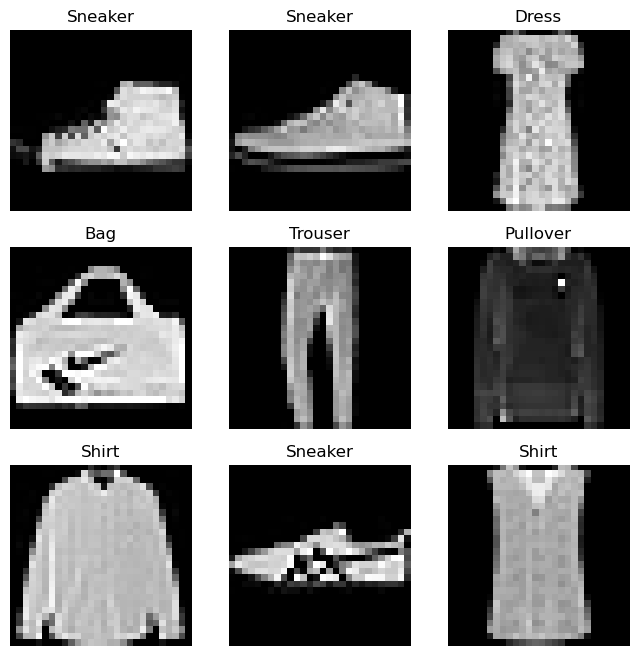

In [6]:
figure = plt.figure(figsize=(8,8))
cols, rows = 3, 3
for i in range(1, cols*rows + 1):
    sample_idx = torch.randint(len(training_data), size=(1,)).item() # get a random integer as an index. .item() method extracts the value of a single entry
    img, label = training_data[sample_idx]
    figure.add_subplot(cols, rows, i) # add subplots
    plt.title(labels_map[label])
    plt.axis('off')
    plt.imshow(img.squeeze(), cmap='gray') # .squeeze() method removes any dimensions of size 1


## Transforming (Data Preprocessing)

We want to train a neural network for classifying the FashionMNIST images. But before we do that, we want to make some minor adjustments to our data so that it will be in a form acceptable for training. This doesn't change the information that we have in the data, but is necessary for us to be able to pass the data into a model for training.

In [7]:
from torchvision.transforms import ToTensor, Lambda

ds = datasets.FashionMNIST(
    root = 'data',
    train = True,
    download = True,
    target_transform = Lambda(lambda y:
                              torch.zeros(10, dtype = torch.float).scatter_(0, torch.tensor(y), value = 1))
)

## Building the Model

Now we are ready to build our nueral network model. In PyTorch, every neural network subclasses from torch.nn.Module, and is required to have `__init__` and `forward`.

But before we do that, it helps to have a good hardware to speed up our training time. The following selects a fancy hardware so that, in case we do have any at hand, we can use them. If you don't know what MPS or GPU is, don't worry about what the following code is doing. It is simply picking a good device at our hand.

In [8]:
device = ('cuda' if torch.cuda.is_available()
          else
          'mps' if torch.backends.mps.is_available()
          else
          'cpu'
         )

print(f'Using {device} device')

Using cpu device


Now we build our model.

In [9]:
from torch import nn

class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
                    nn.Linear(28*28, 512), # The expected input for our neural network is 28*28 = 784
                    nn.ReLU(),
                    nn.Linear(512, 512),
                    nn.ReLU(),
                    nn.Linear(512, 10),
        )
    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

The neural network we created is a fully connected neural network that has the dimension of the input vector as `28*28 = 784`. Its first hidden layer has the output vector dimension as 512, applies the ReLU function. The output vector from the first layer gets passed onto the second layer, whose output vector has dimension 512 also. We apply the ReLU function again to the output of the second hidden layer, and the third layer takes that and outputs a vector of dimension 10. When we input a 28 by 28 image, it first gets flattened by `nn.Flatten()` to be transformed into a vector of size 784, and then gets passed through the layers.

We now create an instance of `NeuralNetwork` and move it to the `device` that we have, and print its structure.

In [10]:
model = NeuralNetwork().to(device)
print(model)

NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=10, bias=True)
  )
)


To use the model, we pass it the input data. This will execute the mode's `forward` method, along with some background operations. We do not call `model.forward()` directly.

Calling the model on an input returns a 2D tensor with rows as individual images and columns as individual raw predicted values. For example:

In [11]:
X = torch.rand(3, 28, 28, device = device)
logits = model(X)
print(logits)

tensor([[-0.0908,  0.0070, -0.1127, -0.1024,  0.1180,  0.0823,  0.0275,  0.0201,
          0.0221,  0.0119],
        [-0.0589,  0.0512, -0.0722, -0.1110,  0.0510,  0.0715,  0.0578,  0.0540,
          0.0155,  0.0237],
        [-0.0393,  0.0132, -0.0749, -0.0476,  0.0681,  0.0777,  0.0447,  0.0133,
          0.0081,  0.0680]], grad_fn=<AddmmBackward0>)


As you can see, the fianl output is not a probability, since if they were, the second row (for example) would add up to 1, which is not the case (each entry in the 10 columns in the second rows are mostly less than 0.1). In theory, the output of the `nn.Linear(512,10)` layer can be any real number, but since we have pre-applied the `ToTensor` method as `target_transform` in the training set, the raw output `logits` above will typically have small values.

We now pass the prediction through an instance of the `nn.Softmax` module.

In [12]:
softmax = nn.Softmax(dim=1) # dim=1 means that the softmax function will be applied along the second dimension, so that the sum of entries in each row will be 1
pred_probs = softmax(logits)
print(pred_probs)
y_pred = pred_probs.argmax(1)
print(y_pred)

tensor([[0.0912, 0.1006, 0.0893, 0.0902, 0.1124, 0.1085, 0.1027, 0.1019, 0.1021,
         0.1011],
        [0.0933, 0.1042, 0.0921, 0.0886, 0.1042, 0.1063, 0.1049, 0.1045, 0.1005,
         0.1014],
        [0.0948, 0.0999, 0.0915, 0.0940, 0.1055, 0.1065, 0.1031, 0.0999, 0.0994,
         0.1055]], grad_fn=<SoftmaxBackward0>)
tensor([4, 5, 5])


### Optional: What each layers are doing

We take a closer look at what each layers are doing. You can also look these up in the PyTorch website, but we here give a brief demonstrations.

In [13]:
# sample tensor we'll be using
input_image = torch.rand(3, 28, 28)
print(f'The original input size is: {input_image.size()}')

# nn.Flatten
flatten = nn.Flatten()
flat_image = flatten(input_image)
print(f'The size of the tensor after applying nn.Flatten() is: {flat_image.size()}')

The original input size is: torch.Size([3, 28, 28])
The size of the tensor after applying nn.Flatten() is: torch.Size([3, 784])


Notice that `nn.Flatten(input_image)` would give us an error. Instead, it's `nn.Flatten()(input_image)`.

In [14]:
# nn.Linear. The following is the same as nn.Linear(28*28, 20)
layer1 = nn.Linear(in_features = 28*28, out_features = 20)
hidden1 = layer1(flat_image)
print(f'Size of the tensor after applying nn.Linear is: {hidden1.size()}')

Size of the tensor after applying nn.Linear is: torch.Size([3, 20])


In [15]:
# nn.ReLU()
print(f"Before ReLU: {hidden1}\n\n")
hidden1 = nn.ReLU()(hidden1)
print(f"After ReLU: {hidden1}")

Before ReLU: tensor([[ 0.1870, -0.9514,  0.1243, -0.3497, -0.3728, -0.3635,  0.2170,  0.1377,
         -0.3104,  0.3393, -0.0541, -0.0610,  0.1358, -0.2247,  0.0365,  0.2554,
         -0.3283,  0.3719, -0.0969, -0.3449],
        [ 0.0407, -0.5282,  0.5733, -0.6004, -0.5366, -0.1322,  0.2875, -0.0194,
         -0.3333,  0.3306,  0.0414, -0.3533,  0.1580, -0.3714,  0.1039,  0.5302,
         -0.1556,  0.6729,  0.1281,  0.1704],
        [-0.1360, -0.3615, -0.0258, -0.0758, -0.6151, -0.3228,  0.6404,  0.0452,
         -0.6077,  0.2047, -0.2270, -0.4152,  0.1567, -0.2534, -0.1479,  0.6098,
         -0.0227,  0.3462,  0.0735,  0.0626]], grad_fn=<AddmmBackward0>)


After ReLU: tensor([[0.1870, 0.0000, 0.1243, 0.0000, 0.0000, 0.0000, 0.2170, 0.1377, 0.0000,
         0.3393, 0.0000, 0.0000, 0.1358, 0.0000, 0.0365, 0.2554, 0.0000, 0.3719,
         0.0000, 0.0000],
        [0.0407, 0.0000, 0.5733, 0.0000, 0.0000, 0.0000, 0.2875, 0.0000, 0.0000,
         0.3306, 0.0414, 0.0000, 0.1580, 0.0000, 0.10

`nn.Sequential` is an ordered container of modules. The data is passed through all the modules in the same order as defined.

In [16]:
seq_modules = nn.Sequential(
    flatten,
    layer1,
    nn.ReLU(),
    nn.Linear(20,10)
)
input_image = torch.rand(3,28, 28)
logits = seq_modules(input_image)
print(logits)

tensor([[ 0.1708, -0.0255,  0.0236,  0.0456, -0.1212,  0.3107, -0.4031,  0.3220,
          0.0032, -0.2503],
        [ 0.1525, -0.0521,  0.0477,  0.1656, -0.2837,  0.2982, -0.3829,  0.3728,
          0.0026, -0.2522],
        [ 0.1415, -0.0459,  0.1343,  0.0582, -0.0784,  0.2500, -0.4585,  0.3217,
          0.0725, -0.2251]], grad_fn=<AddmmBackward0>)


According to PyTorch guide: "The last linear layer of the neural network returns logits - raw values in $[-\infty, +\infty]$ - which are passed to the nn.Softmax module. The logits are scaled to values $[0,1]$ representing the model’s predicted probabilities for each class. dim parameter indicates the dimension along which the values must sum to 1."

In [17]:
softmax = nn.Softmax(dim = 1)
pred_probab = softmax(logits)

### Model parameters

If you know the theory behind a neural network, you know that there are parameters involved for each layer of our neural network. Subclassing `nn.Module` automatically tracks all field defined inside our model object and we can access all parameters using `parameters()` or `named_parameters()` methods.

We shall interate over each parameter and print its size and its values.

In [18]:
print(f'Model structure: {model}\n\n')

for name, param in model.named_parameters():
    print(f'Layer: {name} | Size: {param.size()} | Values: {param[:2]} \n')

Model structure: NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=10, bias=True)
  )
)


Layer: linear_relu_stack.0.weight | Size: torch.Size([512, 784]) | Values: tensor([[ 0.0029, -0.0161,  0.0186,  ..., -0.0090,  0.0330,  0.0091],
        [ 0.0311, -0.0067,  0.0135,  ...,  0.0307,  0.0290, -0.0293]],
       grad_fn=<SliceBackward0>) 

Layer: linear_relu_stack.0.bias | Size: torch.Size([512]) | Values: tensor([0.0061, 0.0223], grad_fn=<SliceBackward0>) 

Layer: linear_relu_stack.2.weight | Size: torch.Size([512, 512]) | Values: tensor([[ 0.0240, -0.0327, -0.0384,  ...,  0.0054, -0.0282, -0.0338],
        [ 0.0440,  0.0285, -0.0212,  ..., -0.0150, -0.0198, -0.0066]],
       grad_fn=<SliceBackward0>) 

Layer: linear_relu_stack.2.bias | Size:

## Backpropagation

In order to do gradient descent, we implement the backpropagation algorithm which is just chain rule in calculating the derivative. To compute the gradients, we use the PyTorch's built-in differentiation engine called `torch.autograd`. We first take a look at a simple case.

In [19]:
x = torch.ones(5)
y = torch.zeros(3)
w = torch.randn(5, 3, requires_grad = True)
b = torch.randn(3, requires_grad = True)
z = torch.matmul(x, w) + b
loss = torch.nn.functional.binary_cross_entropy_with_logits(z,y)

Here, the `requires_grad = True` tells PyTorch that we are going to differentiate the loss function with respect to those variables.

According to PyTorch guide, "a function that we apply to tensors to construct computational graph is in fact an object of class `Function`. This object knows how to compute the function in the *forward* direction ... as well as the *backward* direction, e.g. backpropagation. A reference to the backward propagation function is stored in `grad_fn` property of a tensor."

In [20]:
print(f"Gradient function for z = {z.grad_fn}")
print(f"Gradient function for loss = {loss.grad_fn}")

Gradient function for z = <AddBackward0 object at 0x0000019552FF53F0>
Gradient function for loss = <BinaryCrossEntropyWithLogitsBackward0 object at 0x0000019552FF5390>


Now we computer the derivative with respect to the variables for which we have `requres_grad = True`, i.e. we compute $\frac{\partial L}{\partial w}$ and $\frac{\partial L}{\partial b}$ where $L$ is `loss`.

In [21]:
loss.backward()
print(w.grad)
print(b.grad)

tensor([[0.2803, 0.0461, 0.0003],
        [0.2803, 0.0461, 0.0003],
        [0.2803, 0.0461, 0.0003],
        [0.2803, 0.0461, 0.0003],
        [0.2803, 0.0461, 0.0003]])
tensor([0.2803, 0.0461, 0.0003])


### Disabling Gradient Tracking

From PyTorch documentation: "by default, all tensors with `requires_grad = True` are tracking their computational history and support gradient computation." However, there are cases when we don't want to track that, e.g. when we have already trained the model and we just want to run a vector through the forward loop. Another situation when we don't want to track the gradients is when we want to make some parameters in a neural network as *forzen parameters*, e.g. when we are doing transfer learning. We also speed up computations when we are doing forward pass without gradient tracking. 

we can stop tracking by writing `with torch.no_grad(): ...`.

In [22]:
z = torch.matmul(x, w) + b
print(z.requires_grad)

with torch.no_grad():
    z = torch.matmul(x,w) + b
print(z.requires_grad)

True
False


We can also write `z.detach()` to do the same thing, as follows:

In [23]:
z = torch.matmul(x,w) + b
z_det = z.detach()
print(z_det.requires_grad)

False


## Optimizing Model Parameters

We are now ready to train our data, using a selected optimizer.

In [24]:
# set hyperparameters
learning_rate = 1e-3
batch_size = 64
epochs = 10

In [25]:
learning_rate = 1e-3
batch_size = 64
epochs = 10

We pick an optimizer in `torch.optim`. we then traing the model. According to PyTorch guide:

"Inside the training loop, optimization happens in three steps:

- Call `optimizer.zero_grad()` to reset the gradeitns of model parameters. Gradients by default add up; to prevent double-counting, we explicitly zero them at each iteration.
- Backpropagate the prediction loss with a call to `loss.backward()`. PyTorch deposits the gradients of the loss with respect to each parameter.
- Once we have our gradients, we call `optimizer.step()` to adjust the parameters by the gradients collected in the backward pass."

Below is the full implementation. We frist define a method `train_loop` that loops over our optimization code, and another moethod `test_loop` that evaluates how well our model is performing against our test data.

In [26]:
def train_loop(dataloader, model, loss_fn, optimizer):
    # number of training examples
    size = len(dataloader.dataset)
    print(f"size: {size}")
    # Set the model to training mode - this is important for batch normalization and dropout layers
    # unncessary in this situation but added for best practices
    model.train()
    for batch_num, (X, y) in enumerate(dataloader):
        # make a prediction and compute the loss
        pred = model(X)
        loss = loss_fn(pred, y)

        # backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        # For every 100 batches, print the loss and the number of total data that's been processed so far after the end of the batch
        if batch_num % 100 == 0:
            loss = loss.item()
            current = batch_num*batch_size + len(X)
            print(f"loss: {loss:>7f} [ Processed {current:>5d} images out of the total {size:>5d} images ]")

def test_loop(dataloader, model, loss_fn):
    # set the model to evaluation mode - this is important for batch normalization and dropout layers
    # unncessary in this situation vbut added for best practices
    model.eval()
    # size of the test examples
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    # initialize the test loss function value and the number of correct guesses
    test_loss, correct = 0, 0

    # evaluate the model with torch.no_rad() is important since it ensures that no gradients are computed during test mode
    # also reduces unnecessary gradient computations and memory usages
    with torch.no_grad():
        for X, y in dataloader:
            # make predictions for the current batch
            pred = model(X)
            # add the test loss for our current batch to test_loss; we will take an average of the test loss later
            test_loss += loss_fn(pred, y).item()
            # add the number of correct arguments to the variable `correct`.
            # more specifically, pred.argmax(1) returns the column number (from 0 to 9) of the max number in each row so that the output dim is 1,
            # checks for each entry of the pred.argmax(1) whether that's the correct prediction, getting us a tensor with True or False entry.
            # we then convert that into a numeric (torch.float), so that `True` entries become 1 and `False` entries become 0.
            # we then sum all the 1s, getting us a tensor with a single entry that effectively captures the number of correct predictions.
            # finally, we get the item in that tensor, and add that value to `correct` variable.
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    # compute the average test loss and accuracy. 
    # Notice that test_loss is divided by the total number of batches and not by the total number of test examples, since each loss_fn(pred, y) that we added to test_loss already is an average of a single batch
    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8} \n")

We now initialize the loss function and optimizer, then passing it to `train_loop` and `test_loop` methods.

In [27]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr = learning_rate)

epochs = 15
for t in range(epochs):
    print(f"Epoch {t + 1}\n-------------------------------------")
    train_loop(train_dataloader, model, loss_fn, optimizer)
    test_loop(test_dataloader, model, loss_fn)
print(f"We had {epochs} epochs. Done!")

Epoch 1
-------------------------------------
size: 60000
loss: 2.319693 [ Processed    64 images out of the total 60000 images ]
loss: 2.293995 [ Processed  6464 images out of the total 60000 images ]
loss: 2.285071 [ Processed 12864 images out of the total 60000 images ]
loss: 2.274010 [ Processed 19264 images out of the total 60000 images ]
loss: 2.250558 [ Processed 25664 images out of the total 60000 images ]
loss: 2.229628 [ Processed 32064 images out of the total 60000 images ]
loss: 2.226355 [ Processed 38464 images out of the total 60000 images ]
loss: 2.210713 [ Processed 44864 images out of the total 60000 images ]
loss: 2.187650 [ Processed 51264 images out of the total 60000 images ]
loss: 2.185826 [ Processed 57664 images out of the total 60000 images ]
Test Error: 
 Accuracy: 45.8%, Avg loss: 2.1607079490734513 

Epoch 2
-------------------------------------
size: 60000
loss: 2.167321 [ Processed    64 images out of the total 60000 images ]
loss: 2.135589 [ Processed  64

Notice that with a CPU it takes quite some time to run the above. We can see a benefit of having using the Stochastic Gradient Descent, `torch.optim.SGD`.

Notice also that the test accuracy increases for each epoch.

## Saving the Model

We now save our model. the learned parameters is internally stored in an internal state dictionary called `state_dict`.

A `.pth` file is a common file extension used in PyTorch to save model weights or entire models.

In [28]:
import torch
import torchvision.models as models

# save the model parameters by called torch.save
torch.save(model.state_dict(), 'model_weights.pth')

To load a model weight, we first create an instance of the same model first, and then load the parameters using `load_state_dict()` method.

In [30]:
# initialize the same model structure. Notice that this model has untrained parameters
another_model = NeuralNetwork().to(device)
# loading the trained weights to our another_model
another_model.load_state_dict(torch.load('model_weights.pth'))

# for consistent inference results
model.eval()

C:\Users\srhee\AppData\Local\Temp\ipykernel_2508\3151015651.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  another_model.load_state_dict(torch.load('model_weights.pth')

NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=10, bias=True)
  )
)

According to PyTorch guide: "be sure to call `model.eval()` method before inferencing to set the dropout and batch normalization layers to evaluation mode. Failing to do this will yield inconsistent inference results."

If we want to save not only the weights but also the model structure, we can pass the model directly to `torch.save` rather than the `model.state_dict`.

In [31]:
# save the model structure *and* the model parameter
torch.save(model, 'model.pth')

# if we want to load the model, we can do like this
yet_another_model = torch.load('model.pth')

C:\Users\srhee\AppData\Local\Temp\ipykernel_2508\3616403566.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  yet_another_model = torch.load('model.pth')


Thank you for reading! All the above *very closely* follows the [PyTorch Learn the Basics guide](https://pytorch.org/tutorials/beginner/basics/intro.html). More information about this can be found in the link.